# [CMI-SleepState-Detection](https://www.kaggle.com/competitions/child-mind-institute-detect-sleep-states/overview)
## Child Mind Institute - Detect Sleep States
### Detect sleep onset and wake from wrist-worn accelerometer data
_______________________________________________________________________ 
# Author Details:
- Name: Najeeb Haider Zaidi
- Email: zaidi.nh@gmail.com
- Profiles: [Github](https://github.com/snajeebz)  [LinkedIn](https://www.linkedin.com/in/najeebz) [Kaggle](https://www.kaggle.com/najeebz)
- License: Private, Unlicensed, All the files in this repository under any branch are Prohibited to be used commercially or for personally, communally or privately unless permitted by author in writing.
- Copyrights 2023-2024 (c) are reserved only by the author: Najeeb Haider Zaidi
________________________________________________________________________
# Attributions:
The Dataset has been provided by Child Mind Institute. in [Kaggle Competition](https://www.kaggle.com/competitions/child-mind-institute-detect-sleep-states/overview) which the author is participating in and authorized to use the dataset solely for the competition purposes.
________________________________________________________________________

In [1]:
import numpy as np # linear algebra
import pandas as pd# data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from datetime import datetime as dts
pd.set_option('display.max_row', 500)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/train-series-modified/df_mod.parquet
/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet
/kaggle/input/child-mind-institute-detect-sleep-states/sample_submission.csv
/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv
/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet


In [2]:
df=pd.read_parquet(path="/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet", engine='auto')

In [3]:
train_events=pd.read_csv("/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv")

In [4]:
#'2018-08-14T15:30:00-0400'
#"2022-04-07T08:53:42.06717+02:00"
def tscv(dt):
    d=dts.strptime(dt, "%Y-%m-%dT%H:%M:%S%z")
    #d = dts.fromisoformat(dt)
    ts=dts.timestamp(d)
    #print('=', end ="")
    return ts

In [5]:
df['ts']=df['timestamp'].apply(lambda x: tscv(x))
df.sort_values(by=['series_id', 'ts','step'])
df.to_parquet('df_mod.parquet')


In [6]:
df.head()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

,series_id,step,timestamp,anglez,enmo,ts
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.6367,0.0217,1.534275e+09
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.6368,0.0215,1.534275e+09
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.6370,0.0216,1.534275e+09
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.6368,0.0213,1.534275e+09
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.6368,0.0215,1.534275e+09


In [7]:
df.sort_values(by=['series_id', 'ts','step'])

,series_id,step,timestamp,anglez,enmo,ts
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.636700,0.0217,1.534275e+09
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.636800,0.0215,1.534275e+09
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.637000,0.0216,1.534275e+09
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.636800,0.0213,1.534275e+09
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.636800,0.0215,1.534275e+09
...,...,...,...,...,...,...
127946335,fe90110788d2,592375,2017-09-08T00:14:35-0400,-27.277500,0.0204,1.504844e+09
127946336,fe90110788d2,592376,2017-09-08T00:14:40-0400,-27.032499,0.0233,1.504844e+09
127946337,fe90110788d2,592377,2017-09-08T00:14:45-0400,-26.841200,0.0202,1.504844e+09
127946338,fe90110788d2,592378,2017-09-08T00:14:50-0400,-26.723900,0.0199,1.504844e+09


## Investigating around onset event

In [8]:
df['anglez'][(df['series_id']=='038441c925bb') & (df['timestamp']=="2018-08-14T22:26:00-0400")]

4992   -78.690598
Name: anglez, dtype: float32

In [9]:
print("Mean enmo before Event: ",df['enmo'].loc[0:4992].mean())
print("Mean enmo between Events: ",df['enmo'].loc[4992:10932].mean())
print('Time start: ', df['timestamp'].loc[4992]," Time End: ",df['timestamp'].loc[10932] )
print("Total Time Difference in hrs: ", (df['ts'].loc[10932] - df['ts'].loc[4992])/3600)

Mean enmo before Event:  0.05630563
Mean enmo between Events:  0.01075366
Time start:  2018-08-14T22:26:00-0400  Time End:  2018-08-15T06:41:00-0400
Total Time Difference in hrs:  8.25


In [10]:
print(df.loc[(4992-50):(4992+50)])

         series_id  step                 timestamp     anglez    enmo  \
4942  038441c925bb  4942  2018-08-14T22:21:50-0400 -34.077801  0.0011   
4943  038441c925bb  4943  2018-08-14T22:21:55-0400 -33.305199  0.0008   
4944  038441c925bb  4944  2018-08-14T22:22:00-0400 -32.158001  0.0029   
4945  038441c925bb  4945  2018-08-14T22:22:05-0400 -31.564501  0.0032   
4946  038441c925bb  4946  2018-08-14T22:22:10-0400 -30.303699  0.0030   
4947  038441c925bb  4947  2018-08-14T22:22:15-0400 -28.724199  0.0028   
4948  038441c925bb  4948  2018-08-14T22:22:20-0400 -28.379601  0.0009   
4949  038441c925bb  4949  2018-08-14T22:22:25-0400 -28.398001  0.0006   
4950  038441c925bb  4950  2018-08-14T22:22:30-0400 -30.009899  0.0067   
4951  038441c925bb  4951  2018-08-14T22:22:35-0400 -33.668499  0.0042   
4952  038441c925bb  4952  2018-08-14T22:22:40-0400 -33.095100  0.0017   
4953  038441c925bb  4953  2018-08-14T22:22:45-0400 -32.048401  0.0043   
4954  038441c925bb  4954  2018-08-14T22:22:50-0400 

## Investigating around wakeup event

In [11]:
df['anglez'][(df['series_id']=='038441c925bb') & (df['timestamp']=="2018-08-15T06:41:00-0400")] #wakeup event recorded precisely at this time

10932   -61.578201
Name: anglez, dtype: float32

In [12]:
px.line(x=df['step'].loc[10932-50:10932+50], y=df['anglez'].loc[10932-50:10932+50])

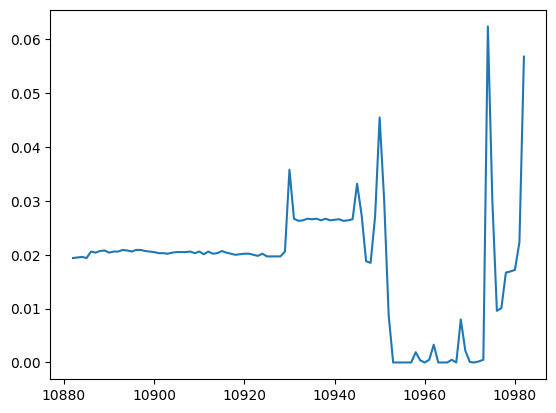

In [13]:
plt.plot(df['step'].loc[10932-50:10932+50], df['enmo'].loc[10932-50:10932+50])